In [1]:
import re
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

## 통합 데이터 로드

In [2]:
total_df = pd.read_csv('../data/team/5_interest_rate.csv')

/tmp/ipykernel_1629231/3485981028.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('../data/team/5_interest_rate.csv')


In [3]:
print(total_df.shape)
print(total_df.columns)

(1128094, 76)
Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)',
       'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', '시군구 번지', '좌표X,좌표Y', '가장 가까운 거리', 'index',
       '역사_ID', '역사명', '호선', '위도', '경도', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리',
       '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호',
       '가장 가까운 버스 정류소명', '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표',
       '가장 가까운 버스 정류장 Y좌표', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리'],
      dtype='obj

In [4]:
total_df.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,가장 가까운 버스 정류소번호,가장 가까운 버스 정류소명,가장 가까운 버스 정류소 타입,가장 가까운 버스 정류장 X좌표,가장 가까운 버스 정류장 Y좌표,인근 버스 정류장 개수,계약년,계약월,GDP,한국은행 기준금리
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,23445.0,개포우성아파트,일반차로,127.057864,37.476564,7.0,2017,12,1623074.1,1.5
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,23445.0,개포우성아파트,일반차로,127.057864,37.476564,7.0,2017,12,1623074.1,1.5
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,23445.0,개포우성아파트,일반차로,127.057864,37.476564,7.0,2017,12,1623074.1,1.5
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,23445.0,개포우성아파트,일반차로,127.057864,37.476564,7.0,2018,1,1725373.4,1.5
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,23445.0,개포우성아파트,일반차로,127.057864,37.476564,7.0,2018,1,1725373.4,1.5


In [5]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 76 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   시군구                   1128094 non-null  object 
 1   번지                    1127867 non-null  object 
 2   본번                    1128019 non-null  float64
 3   부번                    1128019 non-null  float64
 4   아파트명                  1125958 non-null  object 
 5   전용면적                  1128094 non-null  float64
 6   계약년월                  1128094 non-null  int64  
 7   계약일                   1128094 non-null  int64  
 8   층                     1128094 non-null  int64  
 9   건축년도                  1128094 non-null  int64  
 10  도로명                   1128094 non-null  object 
 11  해제사유발생일               6195 non-null     float64
 12  등기신청일자                1128094 non-null  object 
 13  거래유형                  1128094 non-null  object 
 14  중개사소재지                1128094 non-

## 컬럼 삭제

In [6]:
# 추가로 제거가 필요한 feature 제거
total_df.drop([
    # '시군구', 
    # '번지',
    # '도로명',
    # '아파트명', 
    # 'k-건설사(시공사)',
    '본번',
    '부번',
    'k-세대타입(분양형태)', 
    '거래유형', 
    'k-시행사', 
    'k-연면적', 
    'k-주거전용면적',
    'k-관리방식',
    '해제사유발생일',
    '등기신청일자',
    '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-복도유형', 'k-난방방식', 'k-전체동수',
    '세대전기계약방법', '청소비관리형태', '건축면적', 'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', '시군구 번지', 
    '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
    '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
    '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '호선',
    'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자',
    'k-수정일자', '고용보험관리번호', '경비비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
    '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일',
    '계약년', '계약월',
], axis=1, inplace=True)

display(total_df.shape)
display(total_df.columns)
display(total_df.head())

(1128094, 20)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-전체세대수', 'k-건설사(시공사)', '주차대수', 'target', 'is_test', '가장 가까운 거리',
       '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리'],
      dtype='object')

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,k-전체세대수,k-건설사(시공사),주차대수,target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,인근 버스 정류장 개수,GDP,한국은행 기준금리
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,270.0,우성건설,262.0,124000.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5
1,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,270.0,우성건설,262.0,123500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5
2,서울특별시 강남구 개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,270.0,우성건설,262.0,91500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5
3,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,270.0,우성건설,262.0,130000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5
4,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,270.0,우성건설,262.0,117000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5


## 파생변수1 - 세대별 주차대수

In [7]:
total_df['세대별_주차대수'] = total_df['주차대수'] / total_df['k-전체세대수']

total_df.drop(['주차대수', 'k-전체세대수'], axis=1, inplace=True)
display(total_df.shape)
display(total_df.columns)
display(total_df.head())

(1128094, 19)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-건설사(시공사)', 'target', 'is_test', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '세대별_주차대수'],
      dtype='object')

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,k-건설사(시공사),target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,인근 버스 정류장 개수,GDP,한국은행 기준금리,세대별_주차대수
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,우성건설,124000.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037
1,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,우성건설,123500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037
2,서울특별시 강남구 개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,우성건설,91500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037
3,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,우성건설,130000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5,0.97037
4,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,우성건설,117000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5,0.97037


### 파생변수2 - 건설사 랭크

In [8]:
# 동의어 사전
synonyms = {
    '삼성물산': ['삼성물산주식회사', '삼성물산(주)', '삼성물산 건설부문', '삼성물산(주) 건설부문', '삼성물산,두산건설', '삼성물산(주) 주택부문', "삼성건설", "삼성건설(주)", "삼성래미안", "삼성물산",
               "(주)삼성물산", "삼성", "삼성물산", "삼성중공업", "(주)삼성", "삼성물산, 건설부문", "삼성물산, 주택부문"],
    '현대건설': ['현대건설(주)', '현대건설주식회사', '(주)현대건설', '현대산업개발', '현대산업개발(주)', 'HDC현대산업개발', '현대bs&c', '현대BS&C', "(주)현대산업개발", "현대산업개발", 
               "주식회사 현대건설", "현대", "현대산업개발 주", "현대종합건설", "주시회사 현대건설", "현대산업개발", "현대엔지니어링", "현대힐스테이트", "주시회사, 현대건설", "현대건설, 주"],
    '대림산업': ['대림산업(주)', '대림산업주식회사', '(주)대림산업', '대림건설', '대림건설(주)', "(주)대림", "대림", "대림산업", "대림산업 (주)", "대림산업"],
    '대우건설': ['대우건설(주)', '대우푸르지오', "(주)대우", "(주)대우건설", "대우건설", "주)대우건설", "대우경남", "대우", "대우자동차판매"],
    'GS건설': ['GS건설(주)', '지에스 건설', '지에스건설주식회사', '지에스건설(주)', "(주)gs공사", "GS 건설", "GS건설", "GS건설주식회사", "GS자이 건설", "gs건설", "럭키외", "GS", "gs공사",
              'GS건설, unknown', 'GS자이, unknown', "지에스, unknown", '지에스건설'],
    "SK건설": ["(주)에스케이건설", "SK", "에스케이건설"],
    '한라건설': ['(주)한라', '한라건설', '(주)한라건설', '한라'],
    '롯데건설': ['롯데건설(주)', '롯데건설주식회사', "(주)롯데건설", "롯데건설"],
    '한화건설': ['(주)한화건설', '한화건설(주)'],
    '두산건설': ['두산건설주식회사', '두산건설(주)', "두산", "두산건설", "두산건설(주)", "두산건설주식회사"],
    '우성건설': ['우성건설(주)', '(주)우성건설', '우성건설(주)'],
    '포스코건설': ['(주)포스코건설', '포스코, 포스코A&C', '포스코', '포스코', '포스코건설, 포스코A&C'],
    'SH공사': ['sh공사', '에스에이치공사', 'SH', "SH공사", "sh 공사", "sh, 공사", "(주)에스에이치건설", "서울도시개발공사", "주택공사", "도시개발공사", "에스에이치건설"],
    '건영건설': ['(주)건영', '(주) 건영', "(주) 건영", "건영", "건영건설", "건영종합건설(주)", " (주) 건영", "건영종합건설"],
    '신동아건설': ['신동아건설(주)', '신동아 건설(주)', '신동아', '신동아건설', '신동아건설(주)', "신동아건설, unknown"],
    '계룡건설': ['계룡건설(주)', '계룡건설산업(주)'],
    '코오롱건설': ['코오롱글로벌(주)', '코오롱글로벌', '코오롱건설주식회사'],
    '성원건설': ['성원건설(주)', '(주)성원건설'],
    "금호건설": ["(주)금호", "(주)금호건설", "(주)금호산업", "금호", "금호건설", "금호건설(주)", "금호산업", "금호자이"],
    "동아건설": ["(주)동아건설산업", "동아건설", "동아건설산업(주)", "동아건설산업"],
    "동일토건": ["(주)동일토건", "동일토건"],
    "LG건설": ["엘지건설(주)", "엘지건설"],
    "한일건설" : ["한일개발"],
    "삼호건설": ["삼호건설", "삼호주택", "(주)삼호"],
    "서광산업": ["(주)서광건설산업", "서광산업"],
    "서희건설": ["(주)서희건설", "서희건설", "주식회사 서희건설", 'unknown, 서희건설'],
    "신성건설": ["(주)신성건설", "신성건설", "신성건설(주)"],
    "신창건설": ["(주)신창건설", "신창건설", "신창건설(주)->우방건설", "신창건설->우방건설"],
    "쌍용건설": ["(주)쌍용건설", "쌍용건설", "쌍용건설(주)", "쌍용건설(주)", "쌍용"],
    "우방건설": ["(주)우방", "우방", "우방건설"],
    "우리건설": ["(주)우리건설", "우리건설", "우리창우"],
    "일성건설": ["(주)일성건설", "일성건설", "(주)일성건설"],
    "임광건설": ["임광토건(주)"],
    "청구건설": ["청구", "청구주택"],
    "남광건설" : ["남광", "남광토건(주)", "남광토건"],
    "풍림건설" : ["풍림산업"],
    "중앙건설": ["(주)중앙건설", "중앙건설", "중앙건설(주)"],
    "태영건설": ["(주)태영", "(주)태영건설", "태영건설", "태영"],
    "한양건설": ["(주)한양", "(주)한양건설", "한양", "한양건설", "한양", "한양건설", "한양수자인", "한양주택 (주)", "?양건설", "한양산업개발", "한양산업개발(주", "한양주택"],
    "한진건설": ["(주)한진중공업", "한진중공업", "한진중공업(주)", "한진중공업", "한진건설(주)"],
    "한신건설": ["한신공영", "한신공영(주)"],
    "효성건설": ["(주)효성", "(주)효성건설", "효성건설", "효성중공업", "효성"],
    "KCC건설": ["KCC", "kcc건설"],
    "동부건설": ["동부건설", "동부건설(주)", "동부건설(주)외1", "동부건설외1"],
    "이수건설": ["이수건설", "이수건설(주)", "이수건설,대우엔지니어링"],
    "삼성중공업": ["삼성중공업", "삼성중공업(주)"],
    "호반건설" : ["(주)호반건설"],
    "LIG건설" : ["LIG건설", "LIG건설(주)"],
    "경남기업": ["경남기업", "경남기업(주)"],
    "경향건설": ["경향건설(주)"],
    "계룡건설": ["계룡건설산업", "계룡건설(주)", "계룡건설산업(주)"],
    "고려개발": ["고려개발", "고려개발(주)", "고려산업개발", "고려산업개발(주)", "고려개발(주)", "고려산업개발", "고려산업개발(주)"],
    "극동건설" : ["극동건설", "극동건설(주)"],
    "나산건설" : ["나산종합건설"],
    "라이프건설": ["라이프주택"],
    "신도건설": ["(주)신도종합건설", "신도종합건설"],
    "쌍용건설": ["쌍용"],
    "우림건설": ["우림건설", "우림건설(주)"],
    "유원건설": ["유원건설", "유원건설(주)", '울트라건설', '울트라건설(주)', "유원울트라", "유원"],
    "월드건설": ['월드건설', '월드건설(주)'],
    '인정건설' : ['인정건설', '인정건설(주)'],
    "흥화건설": ["흥화공업", "흥화공업(주)"],
    "한솔건설": ["한솔"],
    "한보건설": ["한보", "한보철강", "한보철강", '한보철상'],
    "고려개발": ["고려개발 "],
    "동양메이저건설": ["동양메이저(주)", "동양고속건설주식회사", "동양메이저"],
    "동일건설": ["동일토건", "동일하이빌", "동일", "동일하이빌"],
    "두산건설": ["두산", "두산중공업"],
    "미주건설": ["미주실업주식회사", "미주실업"],
    "벽산건설": ["벽산건설(주)"],
    "삼익건설": ["삼익주택(주)", "삼익주택", "삼익주택(주)", "삼익건설(주)", "unknown, 삼익건설", "청담삼익아파트"],
    "삼정건설": ["삼정기업"],
    "삼환건설": ["삼환기업", "삼환"],
    "세양건설": ["세양건설산업"],
    "신동아건설": ['신동아'],
    "양우건설": ['양우건설(주)', "양우건설사"],
    "우성건설": ["우성"],
    "우정건설": ["우정건설 주식회사", "우정건설, unknown"],
    "중앙건설": ["중앙하이츠", "중앙건설(주)"],
    "진흥건설": ["진흥기업", "진흥연립재건축조합", "진흥기업", "(주)진흥기업", "진흥기업", "진흥기업(주)", "진흥기업"],
    '풍림건설': ['풍림산업(주)', '풍림산업'],
    "신일건업": ['신일산업', '(주)신일건업'],
    "동일건설": ['동일토건', '동일'],
    '세양건설': ['세양건설산업(주)'],
    '라이프건설' : ['라이프주택'],
    '미주건설' : ['미주실업'],
    '선경건설' : ['선경'],
    "unknown" : ['(주)', '주식회사', '건설', 'nan', '박연정', '재건축조합']
}

# (주) 제거하는 함수
def remove_corporate_suffix(name):
    return name.replace('(주)', '').strip()

# 여러 구분자를 처리하는 정규 표현식 패턴
def split_builders(builders):
    pattern = re.compile(r'[\/,\s]+')
    return pattern.split(builders.strip())

# 동의어 대체 함수
def replace_synonyms(value, synonyms_dict):
    for key, values in synonyms_dict.items():
        if value in values:
            return key
    return value

# 여러 문자열을 처리하는 함수
def process_builders(builders, synonyms_dict):
    builders_list = split_builders(builders)
    processed_list = [replace_synonyms(builder, synonyms_dict) for builder in builders_list]
    return ', '.join(processed_list)


# 문자열이 아닌 값을 문자열로 변환
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(lambda x: str(x) if not isinstance(x, str) else x)

# (주) 제거
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(remove_corporate_suffix)

# 동의어 처리 및 리스트를 문자열로 변환
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].apply(lambda x: process_builders(x, synonyms))

In [9]:
total_df['k-건설사(시공사)'] = total_df['k-건설사(시공사)'].replace({
    'GS건설, unknown': 'GS건설',
    'GS자이, unknown': 'GS건설',
    'unknown, 삼익건설' : '삼익건설',
    'unknown, 서희건설' : '서희건설',
    '고려산업개발' : '고려개발',
    "sh, 공사" : "SH공사",
    "동일토건" : "동일건설",
    "동일하이빌" : "동일건설",
    "두산건설주식회사" : "두산건설",
    "미주실업주식회사" : "미주건설",
    "삼성물산, 건설부문" : "삼성물산",
    "삼성물산, 주택부문" : "삼성물산",
    "삼호" : "삼호건설",
    "서광건설산업" : "서광건설",
    "세양건설산업" : "세양건설",
    "신동아건설, unknown" : "신동아건설",
    "우정건설, unknown" : "우정건설",
    "주시회사, 현대건설" : "현대건설",
    "지에스, unknown" : "GS건설",
    "포스코건설, 포스코A&C" : "포스코건설",
    "현대건설, 주" : "현대건설"
})

In [10]:
# 1. target 컬럼값의 로그 변환
total_df["log_target"] = np.log1p(total_df["target"])

# 2. 변환된 target 값의 평균 계산
builder_mean_target = total_df.groupby("k-건설사(시공사)")["log_target"].mean()

# 3. 평균 로그 변환 가격에 따라 랭킹을 매깁니다 (값이 높을수록 높은 랭크)
builder_rankings = builder_mean_target.rank(ascending=False)

# 4. 건설사별 랭킹을 딕셔너리로 변환
builder_rankings_dict = builder_rankings.to_dict()

# 5. df에 '건설사랭크' 컬럼 추가
total_df["건설사랭크"] = total_df["k-건설사(시공사)"].map(builder_rankings_dict)
total_df = total_df.drop(columns=['log_target'])

In [11]:
display(total_df.shape)
display(total_df.columns)
display(total_df.head())

(1128094, 20)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k-건설사(시공사)', 'target', 'is_test', '가장 가까운 거리', '인근 지하철 역 개수',
       '가장 가까운 버스 정류장 거리', '인근 버스 정류장 개수', 'GDP', '한국은행 기준금리', '세대별_주차대수',
       '건설사랭크'],
      dtype='object')

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,k-건설사(시공사),target,is_test,가장 가까운 거리,인근 지하철 역 개수,가장 가까운 버스 정류장 거리,인근 버스 정류장 개수,GDP,한국은행 기준금리,세대별_주차대수,건설사랭크
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,언주로 3,우성건설,124000.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037,106.0
1,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,22,4,1987,언주로 3,우성건설,123500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037,106.0
2,서울특별시 강남구 개포동,658-1,개포6차우성,54.98,201712,28,5,1987,언주로 3,우성건설,91500.0,0,1127.738351,2.0,61.89584,7.0,1623074.1,1.5,0.97037,106.0
3,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,3,4,1987,언주로 3,우성건설,130000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5,0.97037,106.0
4,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201801,8,2,1987,언주로 3,우성건설,117000.0,0,1127.738351,2.0,61.89584,7.0,1725373.4,1.5,0.97037,106.0


## train과 test의 분포 맞춰주기

In [12]:
total_df.drop(columns=['계약일', '층', '건축년도', 'k-건설사(시공사)'], axis=1, inplace=True)
total_df = total_df.rename(columns={'가장 가까운 거리' : '최근접_지하철역_거리',
                                    '인근 지하철 역 개수' : '인근_지하철역_개수',
                                    '가장 가까운 버스 정류장 거리' : '최근접_버스정류장_거리',
                                    '인근 버스 정류장 개수' : '인근_버스정류장_개수',
                                    '한국은행 기준금리' : '기준금리'})

In [13]:
train_df = total_df[total_df['is_test'] == 0]
test_df = total_df[total_df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

(1118822, 15) (9272, 14)


In [14]:
train_df = train_df[train_df['아파트명'].isin(test_df['아파트명'])]
train_df = train_df[train_df['도로명'].isin(test_df['도로명'])]
train_df = train_df[train_df['번지'].isin(test_df['번지'])]
train_df = train_df[train_df['시군구'].isin(test_df['시군구'])]

for index, row in train_df.iterrows():
    if pd.isnull(row['아파트명']):
        corresponding_value = test_df[test_df['아파트명'] == row['아파트명']]['아파트명'].values
        if len(corresponding_value) > 0:
            train_df.at[index, '아파트명'] = corresponding_value[0]

train_df.drop(columns=['시군구', '번지', '아파트명', '도로명'], axis=1, inplace=True)
test_df.drop(columns=['시군구', '번지', '아파트명', '도로명'], axis=1, inplace=True)
display(train_df.shape, test_df.shape)

(821249, 11)

(9272, 10)

## 분포확인

### target

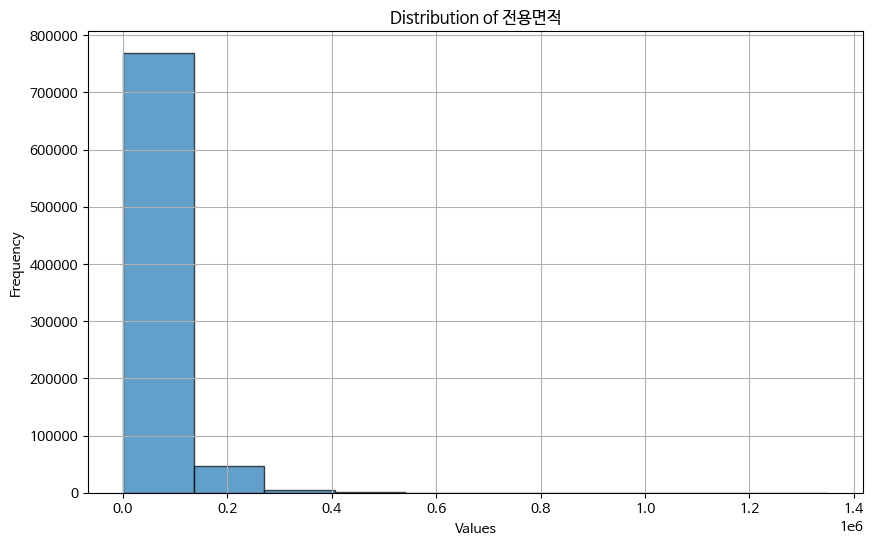

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['target'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

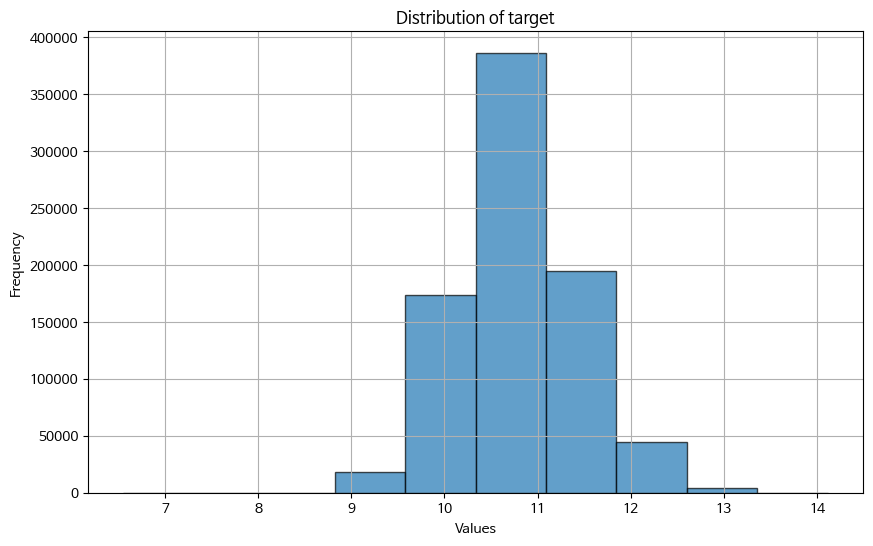

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(train_df['target']), bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of target')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
train_df['target'] = np.log(train_df['target'])

### 전용면적

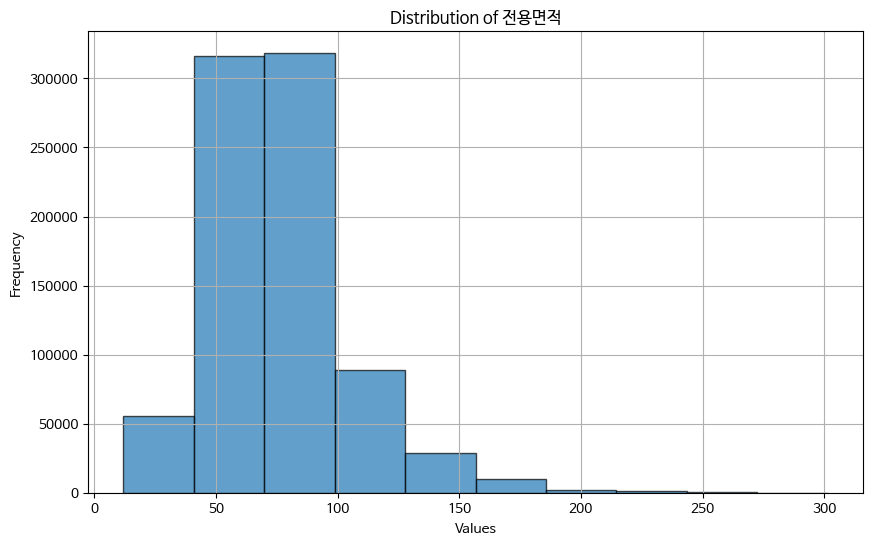

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

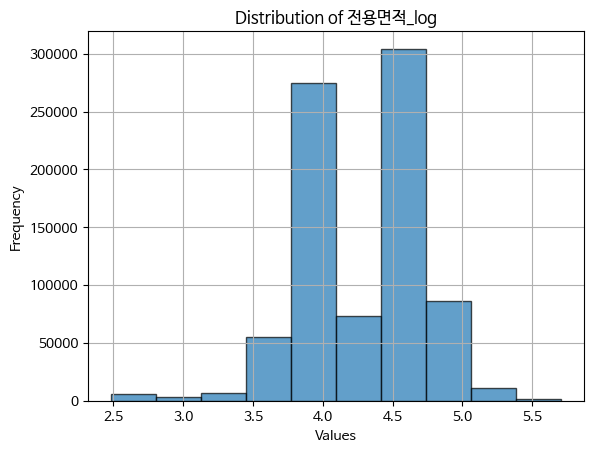

In [19]:
plt.hist(np.log(train_df['전용면적']), bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
scaler = MinMaxScaler()
train_df['전용면적_minmax'] = scaler.fit_transform(np.log(train_df['전용면적']).values.reshape(-1, 1))
test_df['전용면적_minmax'] = scaler.transform(np.log(test_df['전용면적']).values.reshape(-1, 1))

print(train_df.columns)

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax'],
      dtype='object')


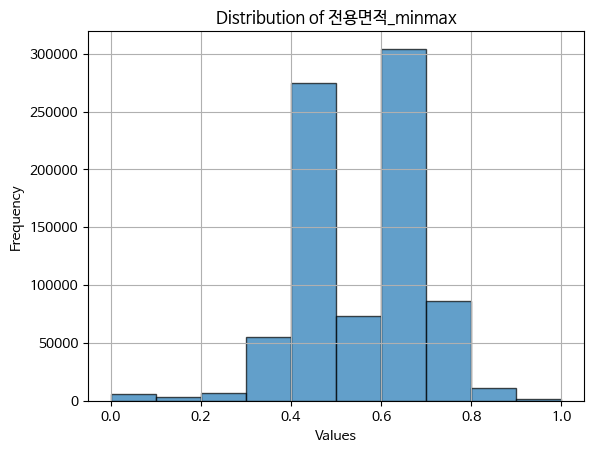

In [21]:
plt.hist(train_df['전용면적_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 계약년월

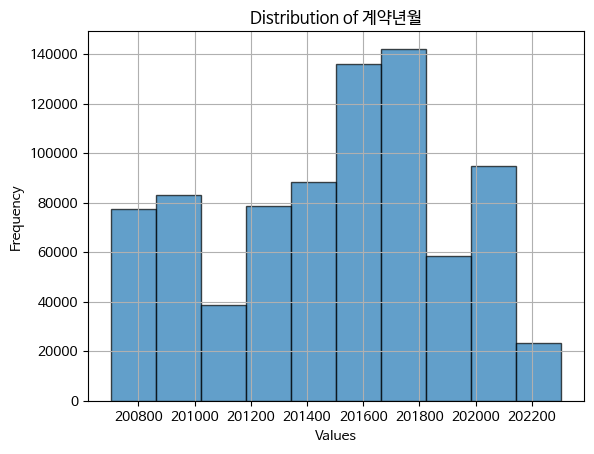

In [22]:
plt.hist(train_df['계약년월'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약년월')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax'],
      dtype='object')


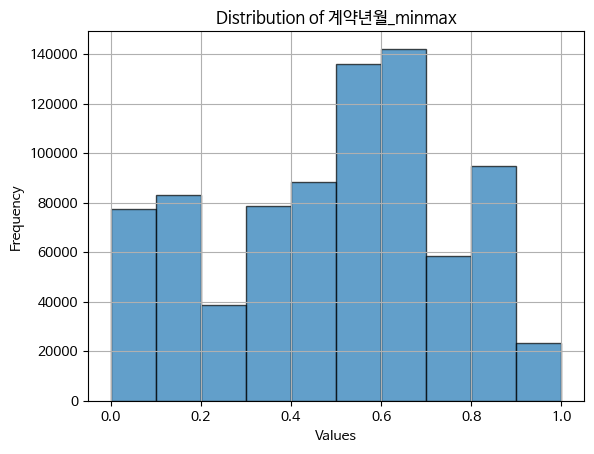

In [23]:
scaler = MinMaxScaler()
train_df['계약년월_minmax'] = scaler.fit_transform(train_df['계약년월'].values.reshape(-1, 1))
test_df['계약년월_minmax'] = scaler.transform(test_df['계약년월'].values.reshape(-1, 1))

print(train_df.columns)
plt.hist(train_df['계약년월_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 계약년월_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 최근접_지하철역_거리

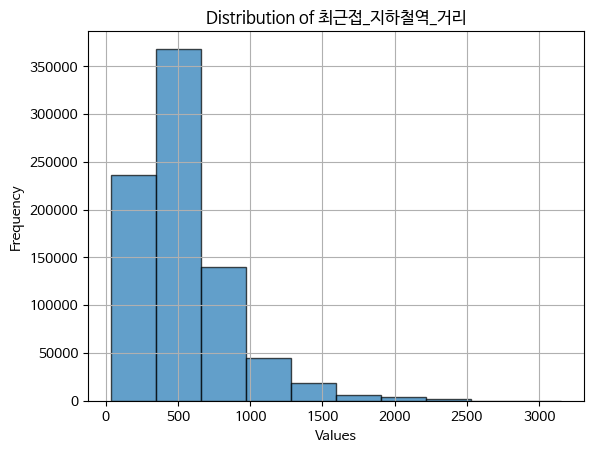

In [24]:
plt.hist(train_df['최근접_지하철역_거리'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역_거리')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

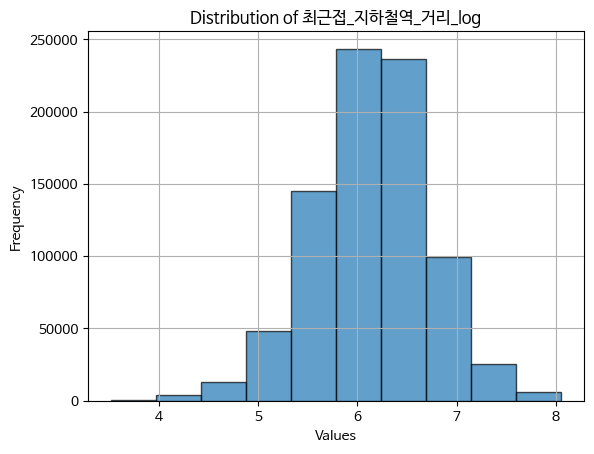

In [25]:
plt.hist(np.log(train_df['최근접_지하철역_거리']), edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역_거리_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax'],
      dtype='object')


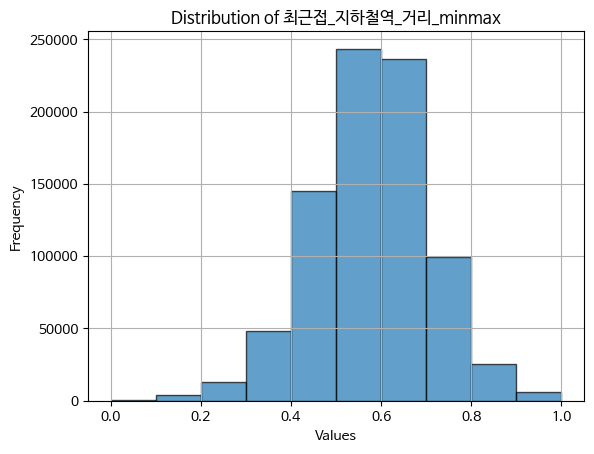

In [26]:
scaler = MinMaxScaler()
train_df['최근접_지하철역_거리_minmax'] = scaler.fit_transform(np.log(train_df['최근접_지하철역_거리']).values.reshape(-1, 1))
test_df['최근접_지하철역_거리_minmax'] = scaler.transform(np.log(test_df['최근접_지하철역_거리']).values.reshape(-1, 1))

print(train_df.columns)
plt.hist(train_df['최근접_지하철역_거리_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_지하철역_거리_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 인근_지하쳘역_개수

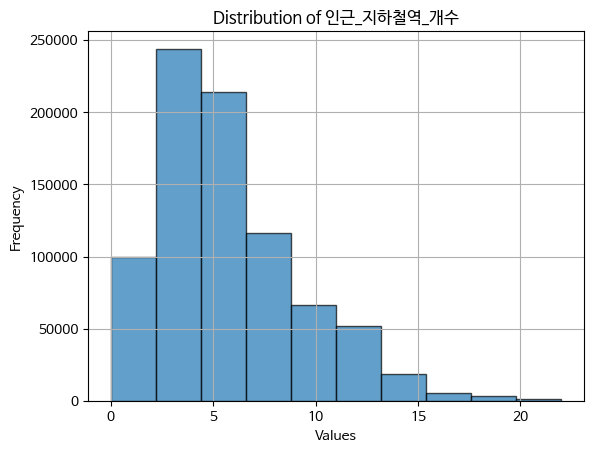

In [27]:
plt.hist(train_df['인근_지하철역_개수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역_개수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

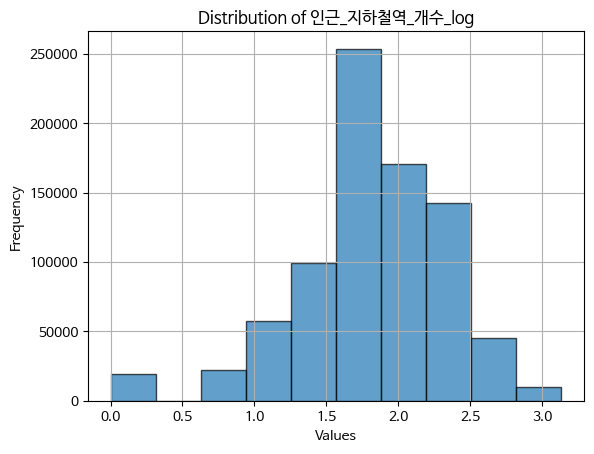

In [28]:
plt.hist(np.log1p(train_df['인근_지하철역_개수']), edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역_개수_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

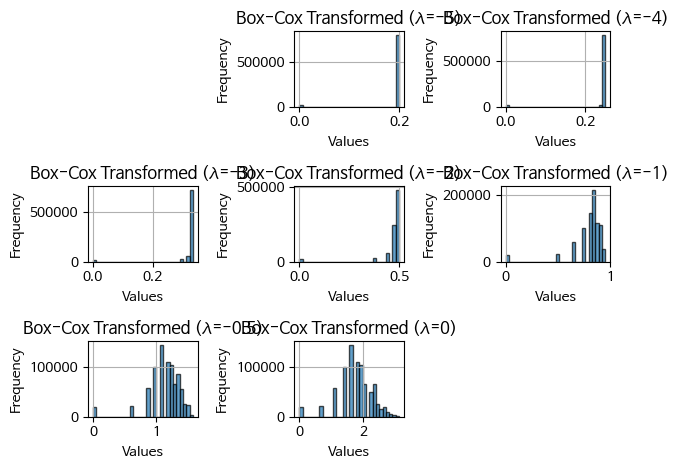

In [29]:
# Box-Cox 변환을 위한 람다 값들
lambdas = [-5, -4, -3, -2, -1, -0.5, 0]

# Box-Cox 변환된 데이터 분포
for i, lam in enumerate(lambdas):
    transformed_data = stats.boxcox(train_df['인근_지하철역_개수'] + 1, lmbda=lam)
    plt.subplot(3, 3, i + 2)
    plt.hist(transformed_data, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Box-Cox Transformed (λ={lam})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax'],
      dtype='object')


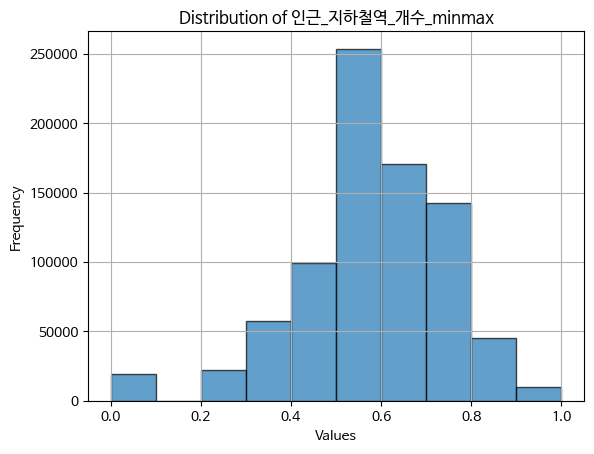

In [30]:
scaler = MinMaxScaler()
train_df['인근_지하철역_개수_minmax'] = scaler.fit_transform(np.log1p(train_df['인근_지하철역_개수']).values.reshape(-1, 1))
test_df['인근_지하철역_개수_minmax'] = scaler.transform(np.log1p(test_df['인근_지하철역_개수']).values.reshape(-1, 1))

print(train_df.columns)
plt.hist(train_df['인근_지하철역_개수_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역_개수_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 최근접_버스정류장_거리

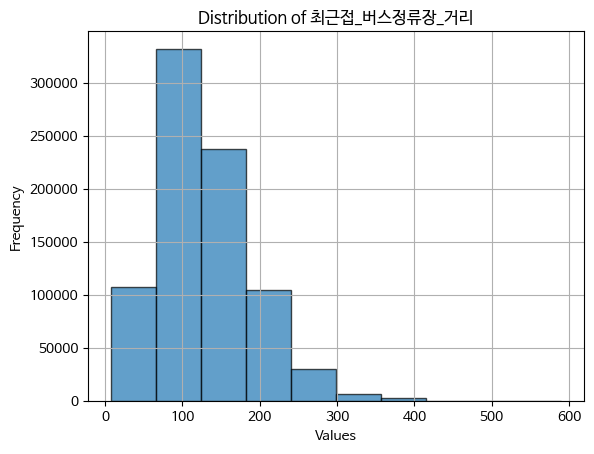

In [31]:
plt.hist(train_df['최근접_버스정류장_거리'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장_거리')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

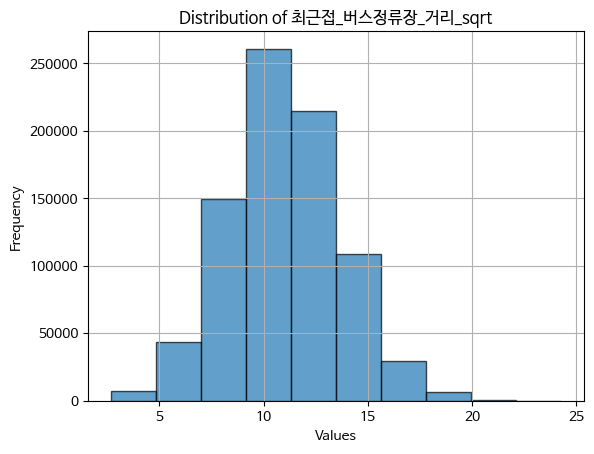

In [32]:
plt.hist(np.sqrt(train_df['최근접_버스정류장_거리']), edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장_거리_sqrt')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

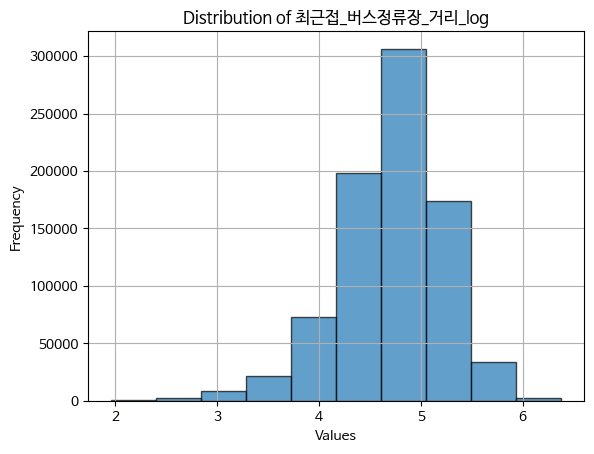

In [33]:
plt.hist(np.log(train_df['최근접_버스정류장_거리']), edgecolor='k', alpha=0.7)
plt.title('Distribution of 최근접_버스정류장_거리_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/tmp/ipykernel_1629231/3610559574.py:14: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/pervinco/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


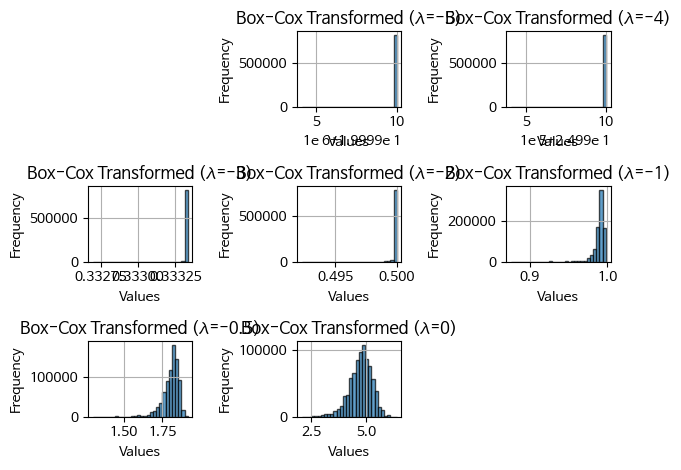

In [34]:
# Box-Cox 변환을 위한 람다 값들
lambdas = [-5, -4, -3, -2, -1, -0.5, 0]

# Box-Cox 변환된 데이터 분포
for i, lam in enumerate(lambdas):
    transformed_data = stats.boxcox(train_df['최근접_버스정류장_거리'] + 1, lmbda=lam)
    plt.subplot(3, 3, i + 2)
    plt.hist(transformed_data, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Box-Cox Transformed (λ={lam})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax'],
      dtype='object')


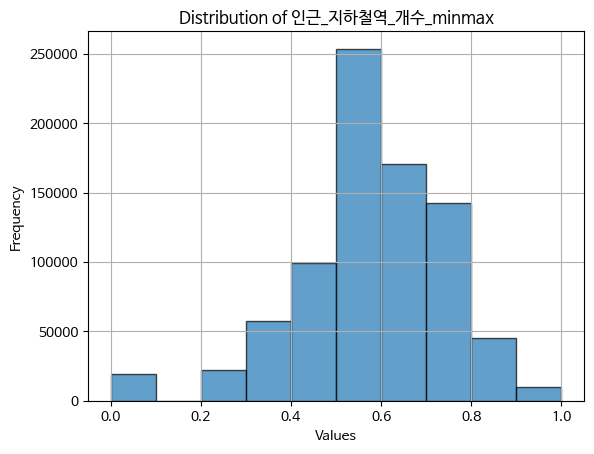

In [35]:
scaler = MinMaxScaler()
train_df['최근접_버스정류장_거리_minmax'] = scaler.fit_transform(np.log1p(train_df['최근접_버스정류장_거리']).values.reshape(-1, 1))
test_df['최근접_버스정류장_거리_minmax'] = scaler.transform(np.log1p(test_df['최근접_버스정류장_거리']).values.reshape(-1, 1))

print(train_df.columns)
plt.hist(train_df['인근_지하철역_개수_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_지하철역_개수_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 인근_버스정류장_개수

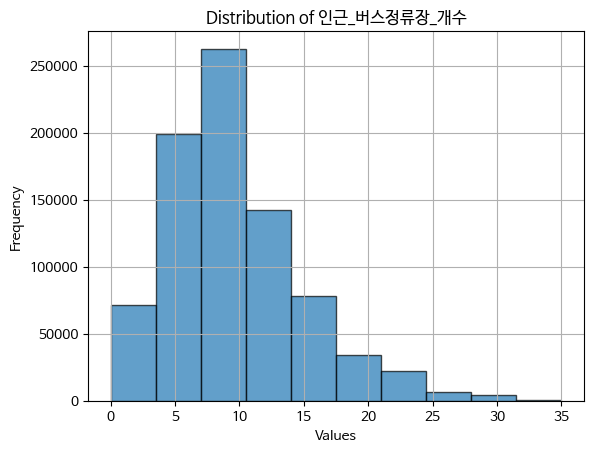

In [36]:
plt.hist(train_df['인근_버스정류장_개수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장_개수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

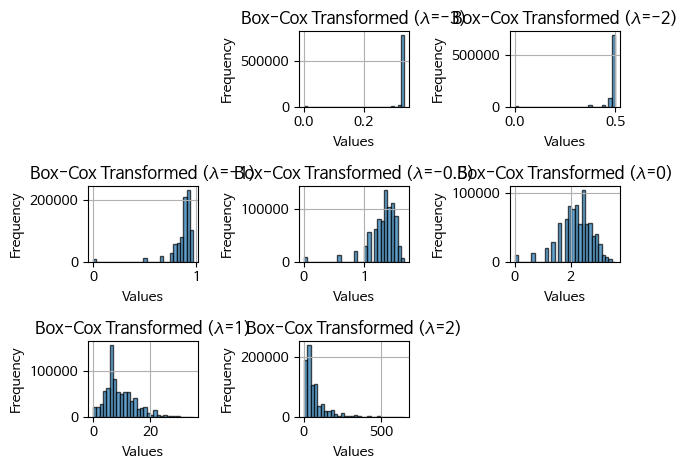

In [37]:
# Box-Cox 변환을 위한 람다 값들
lambdas = [-3, -2, -1, -0.5, 0, 1, 2]

# Box-Cox 변환된 데이터 분포
for i, lam in enumerate(lambdas):
    transformed_data = stats.boxcox(train_df['인근_버스정류장_개수'] + 1, lmbda=lam)
    plt.subplot(3, 3, i + 2)
    plt.hist(transformed_data, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Box-Cox Transformed (λ={lam})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

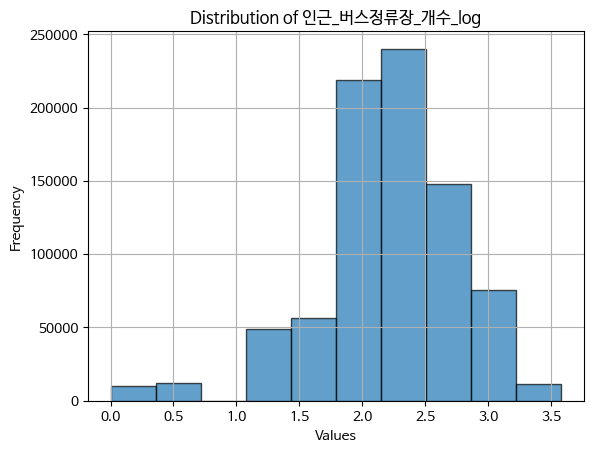

In [38]:
plt.hist(np.log1p(train_df['인근_버스정류장_개수']), edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장_개수_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')


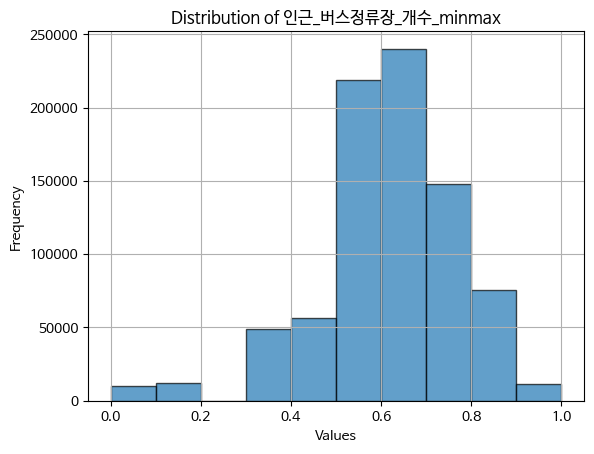

In [39]:
scaler = MinMaxScaler()
train_df['인근_버스정류장_개수_minmax'] = scaler.fit_transform(np.log1p(train_df['인근_버스정류장_개수']).values.reshape(-1, 1))
test_df['인근_버스정류장_개수_minmax'] = scaler.transform(np.log1p(test_df['인근_버스정류장_개수']).values.reshape(-1, 1))

print(train_df.columns)
plt.hist(train_df['인근_버스정류장_개수_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 인근_버스정류장_개수_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### GDP

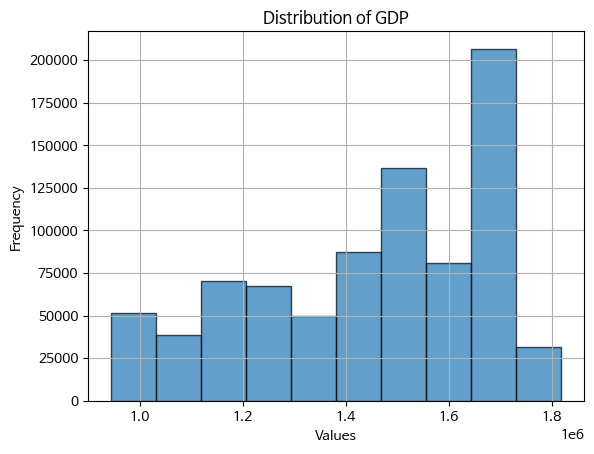

In [40]:
plt.hist(train_df['GDP'], edgecolor='k', alpha=0.7)
plt.title('Distribution of GDP')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 기준금리

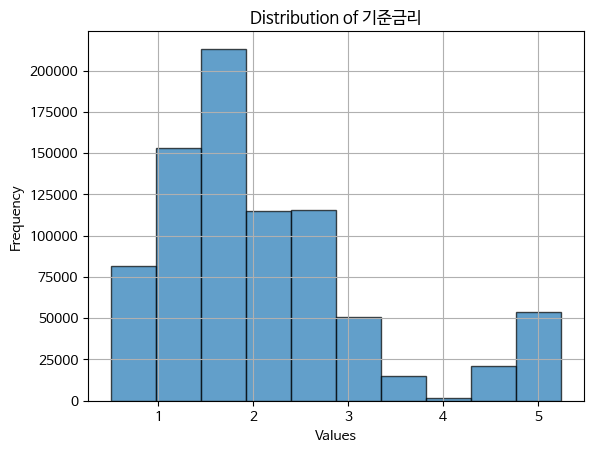

In [41]:
plt.hist(train_df['기준금리'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 기준금리')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [42]:
train_df['기준금리'].value_counts()

기준금리
1.50    167348
1.25    151346
2.00     91639
2.50     80884
0.50     69486
5.00     51065
1.75     46005
3.25     34775
2.75     34650
2.25     23364
4.50     17181
3.00     16105
3.50     14980
0.75     12360
4.75      3841
5.25      2734
1.00      1810
4.25       927
4.00       749
Name: count, dtype: int64

### 세대별_주차대수

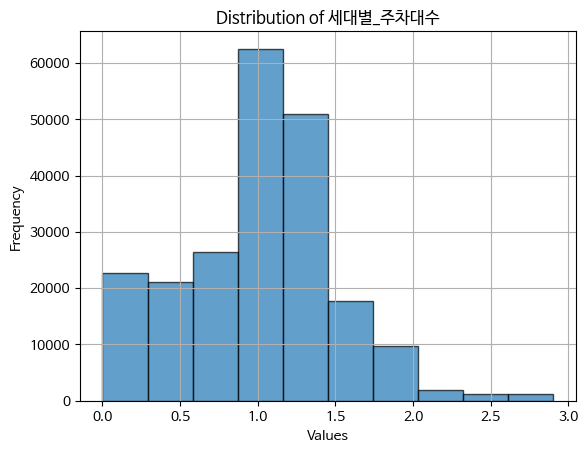

In [43]:
plt.hist(train_df['세대별_주차대수'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 세대별_주차대수')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 건설사랭크

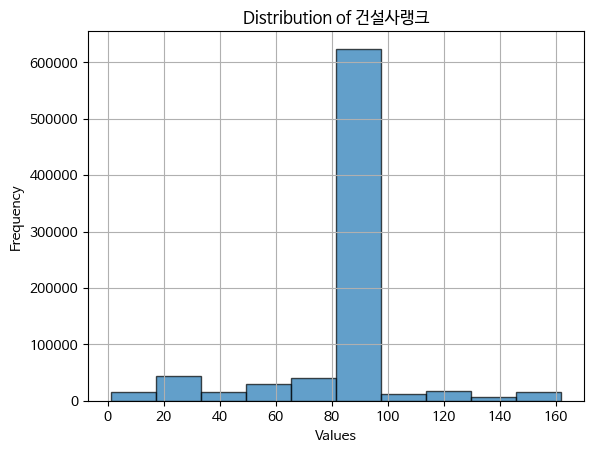

In [44]:
plt.hist(train_df['건설사랭크'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 건설사랭크')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [45]:
scaler = MinMaxScaler()
train_df['건설사랭크'] = scaler.fit_transform(np.log1p(train_df['건설사랭크']).values.reshape(-1, 1))
test_df['건설사랭크'] = scaler.transform(np.log1p(test_df['건설사랭크']).values.reshape(-1, 1))

print(train_df.columns)

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')


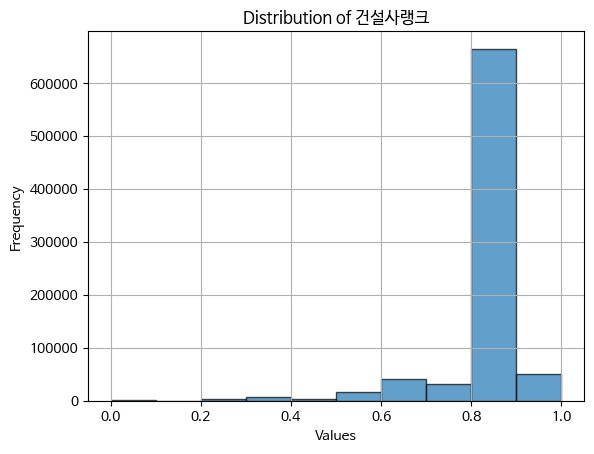

In [46]:
plt.hist(train_df['건설사랭크'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 건설사랭크')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

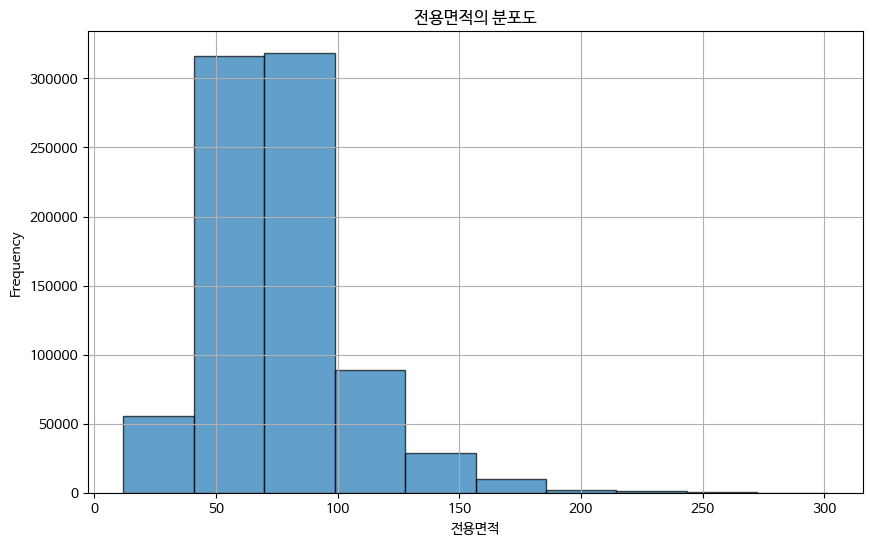

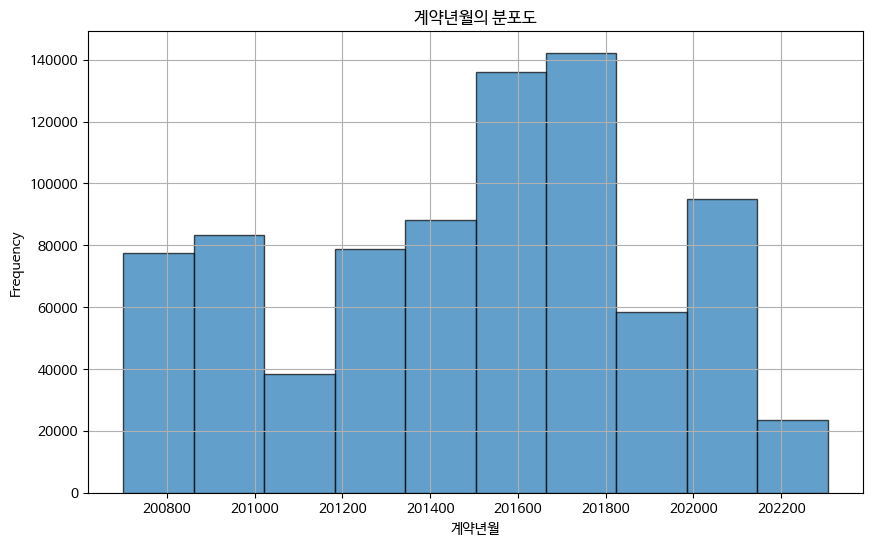

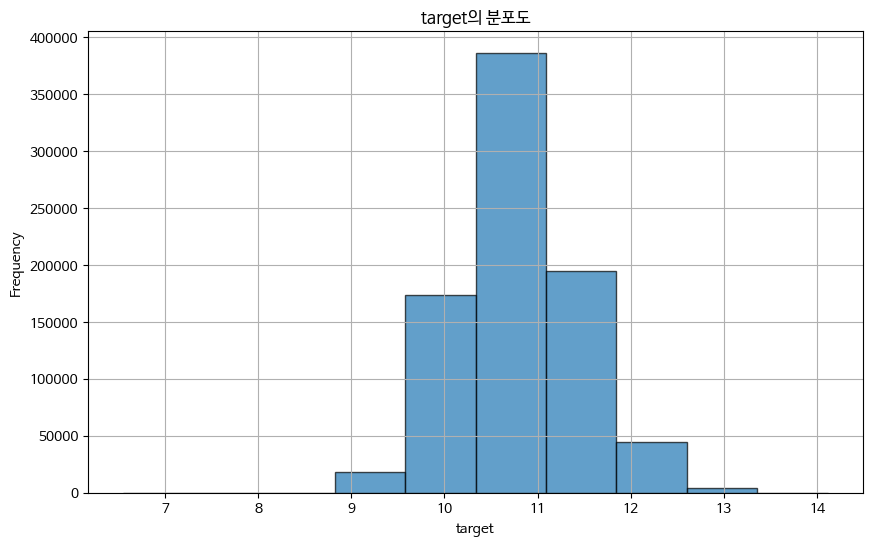

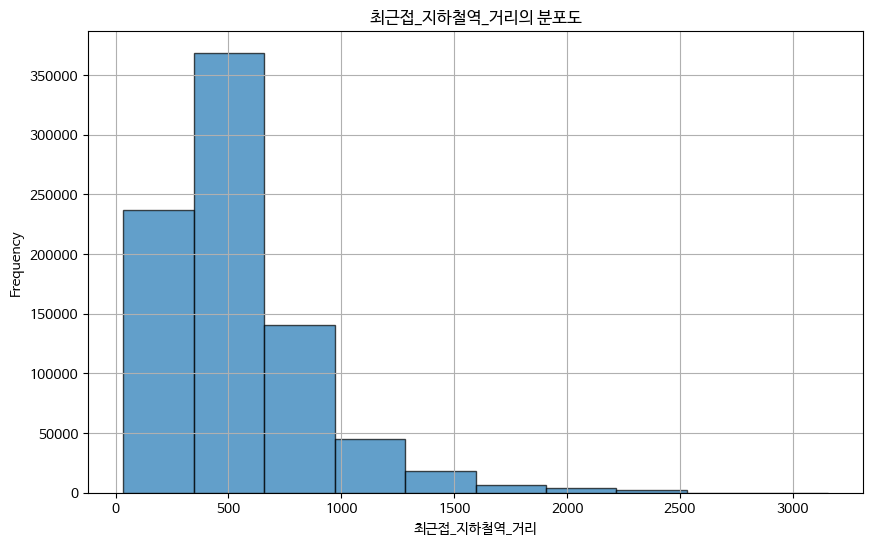

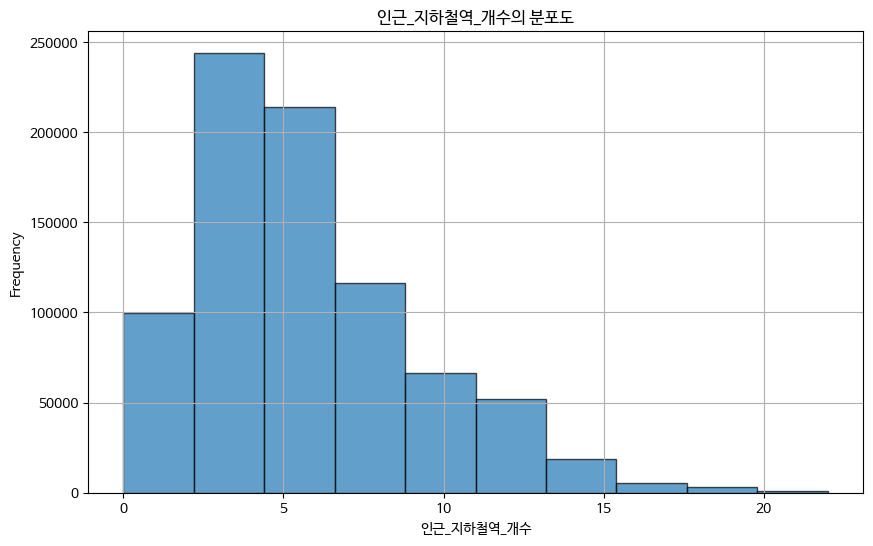

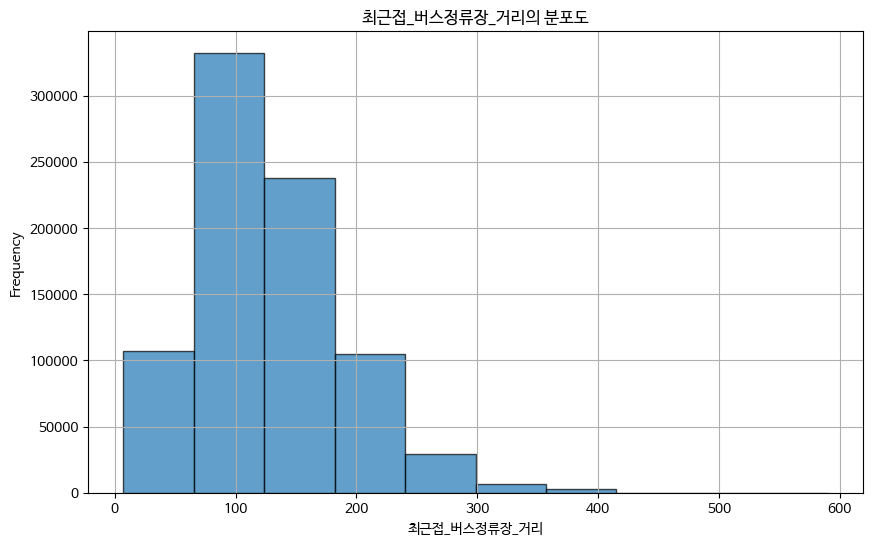

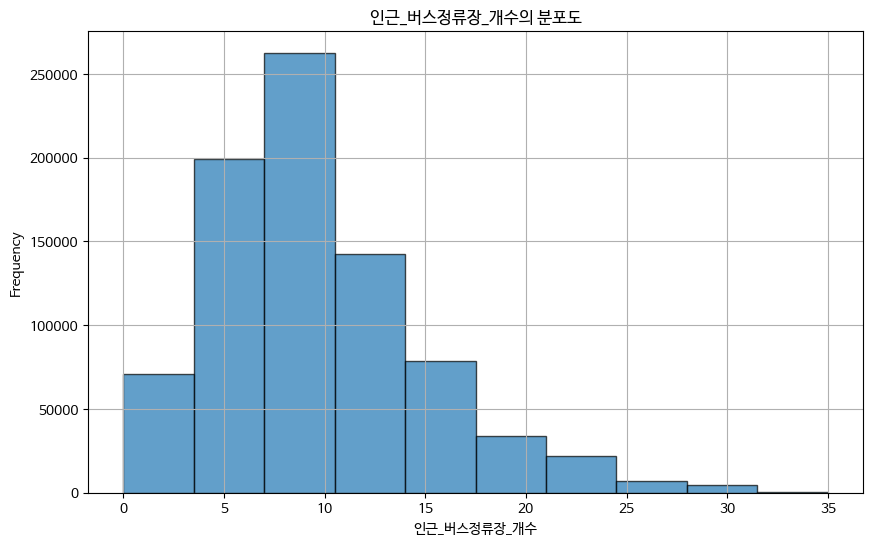

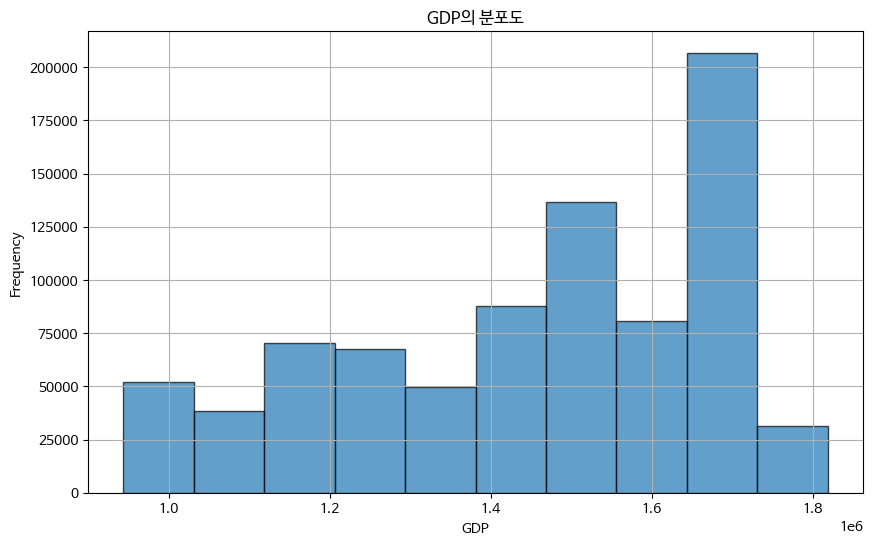

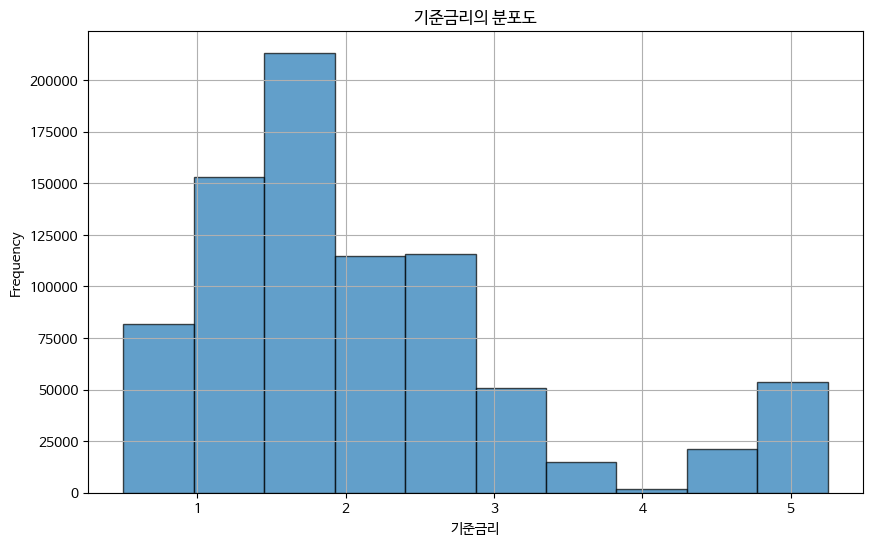

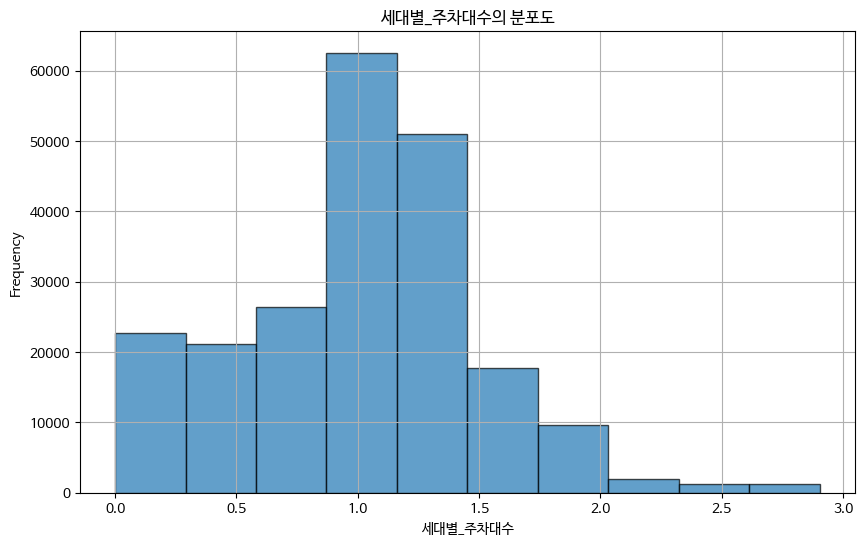

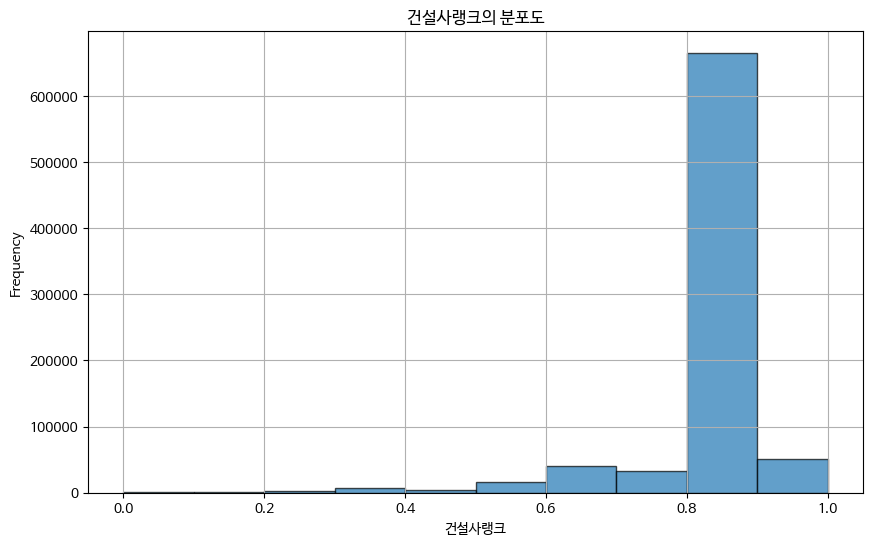

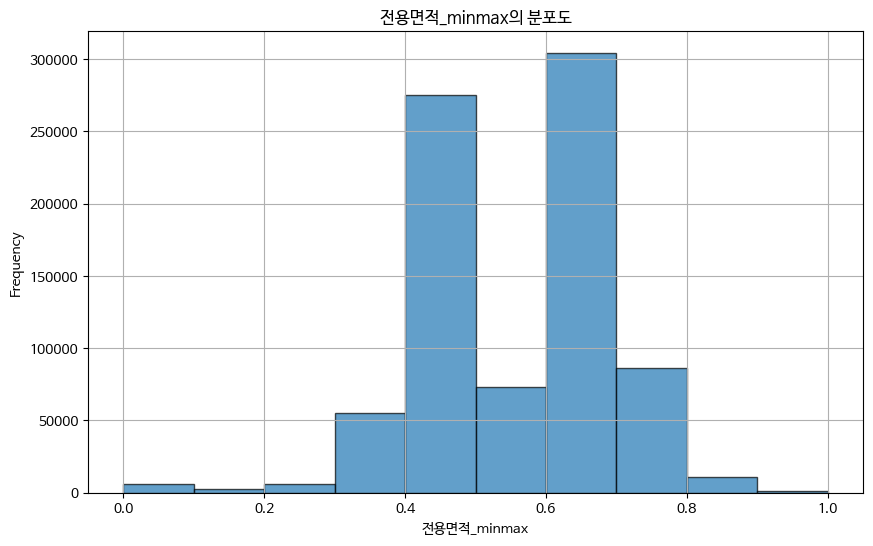

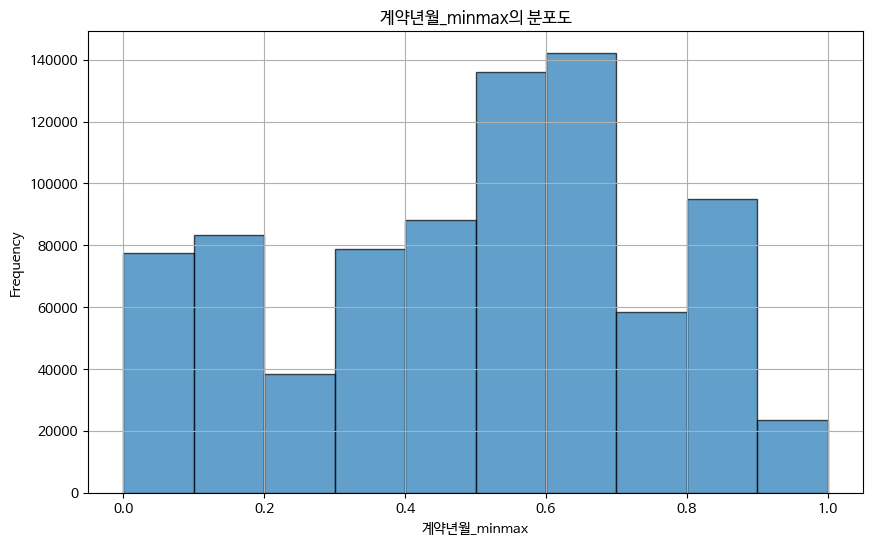

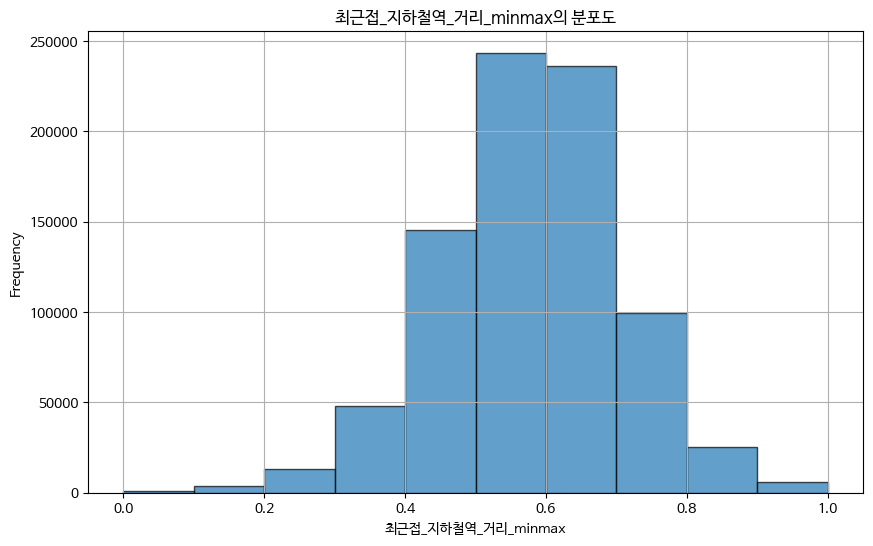

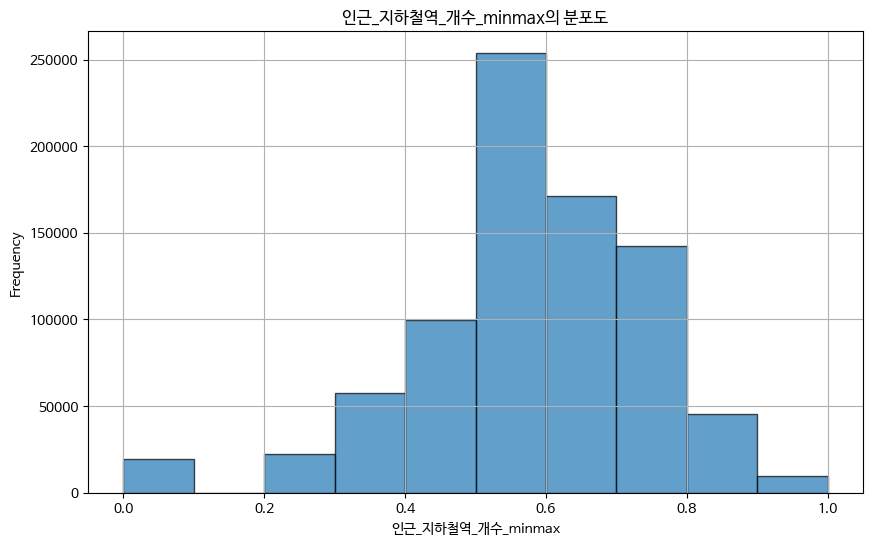

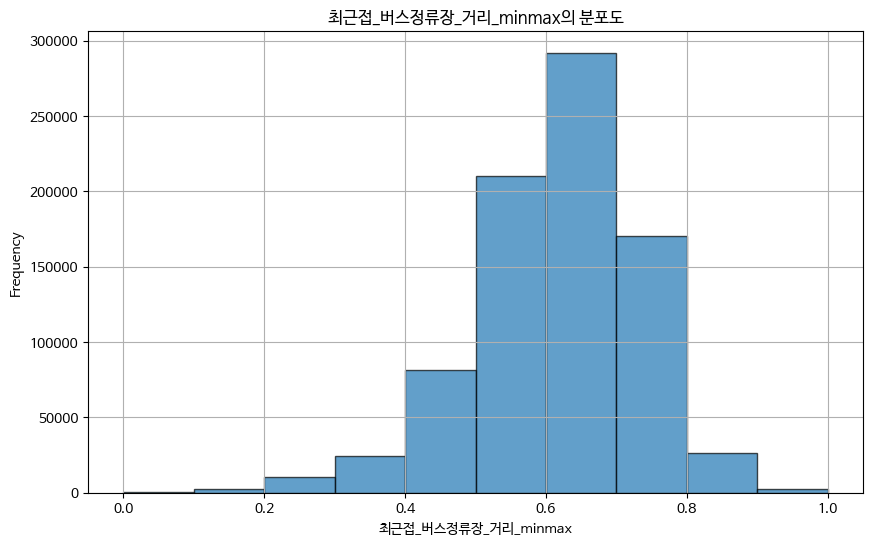

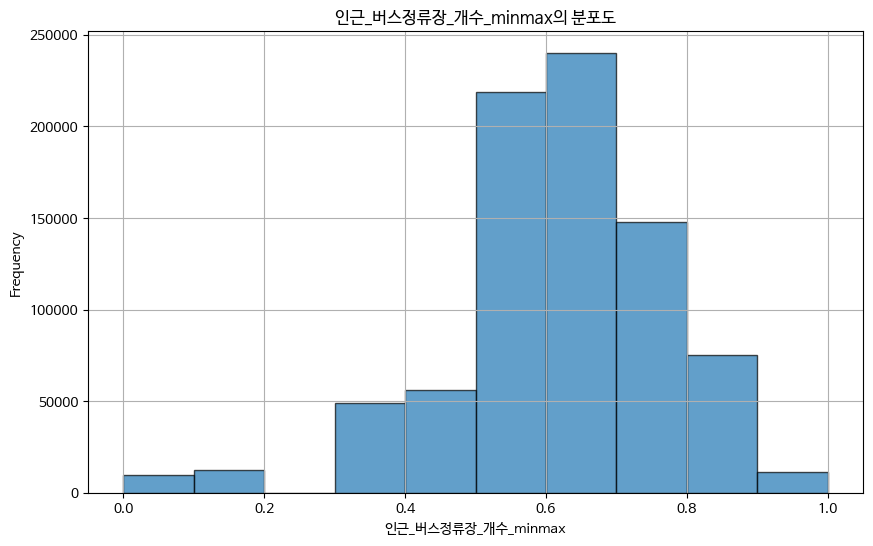

In [47]:
for column in train_df.columns:
    plt.figure(figsize=(10, 6))
    
    if pd.api.types.is_numeric_dtype(train_df[column]):
        # 연속형 변수일 경우 히스토그램
        plt.hist(train_df[column], bins=10, edgecolor='k', alpha=0.7)
        plt.title(f'{column}의 분포도')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
    else:
        # 범주형 변수일 경우 막대 그래프
        train_df[column].value_counts().plot(kind='bar', edgecolor='k', alpha=0.7)
        plt.title(f'{column}의 분포도')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.grid(True)
    plt.show()

# Training

In [48]:
display(train_df.columns)
display(test_df.columns)

Index(['전용면적', '계약년월', 'target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')

Index(['전용면적', '계약년월', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리',
       '인근_버스정류장_개수', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')

In [49]:
display(train_df.shape, test_df.shape)

(821249, 17)

(9272, 16)

In [50]:
train_X = train_df.drop(['target', '최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리', '인근_버스정류장_개수'], axis=1)
train_y = train_df[['target']]

display(train_X.columns)

Index(['전용면적', '계약년월', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')

In [51]:
test_df.drop(columns=['최근접_지하철역_거리', '인근_지하철역_개수', '최근접_버스정류장_거리', '인근_버스정류장_개수'], axis=1, inplace=True)
display(test_df.columns)

Index(['전용면적', '계약년월', 'GDP', '기준금리', '세대별_주차대수', '건설사랭크', '전용면적_minmax',
       '계약년월_minmax', '최근접_지하철역_거리_minmax', '인근_지하철역_개수_minmax',
       '최근접_버스정류장_거리_minmax', '인근_버스정류장_개수_minmax'],
      dtype='object')

In [52]:
params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
}

# KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# KFold 교차 검증 수행
fold = 1
models = []  # 각 fold에서 학습된 모델을 저장할 리스트
for train_index, valid_index in kf.split(train_X):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=60), lgb.log_evaluation(period=10, show_stdv=True)]
    )
    
    models.append(model)
    print(f"Fold {fold} finished.")
    fold += 1

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 0.380787	valid_1's rmse: 0.380913
[20]	training's rmse: 0.310693	valid_1's rmse: 0.311293
[30]	training's rmse: 0.281897	valid_1's rmse: 0.282891
[40]	training's rmse: 0.265219	valid_1's rmse: 0.266323
[50]	training's rmse: 0.251965	valid_1's rmse: 0.253277
[60]	training's rmse: 0.243821	valid_1's rmse: 0.245262
[70]	training's rmse: 0.235756	valid_1's rmse: 0.237207
[80]	training's rmse: 0.229662	valid_1's rmse: 0.231123
[90]	training's rmse: 0.223291	valid_1's rmse: 0.224803
[100]	training's rmse: 0.217785	valid_1's rmse: 0.219361
[110]	training's rmse: 0.212441	valid_1's rmse: 0.214042
[120]	training's rmse: 0.208172	valid_1's rmse: 0.209803
[130]	training's rmse: 0.204313	valid_1's rmse: 0.205916
[140]	training's rmse: 0.201145	valid_1's rmse: 0.202736
[150]	training's rmse: 0.197375	valid_1's rmse: 0.199024
[160]	training's rmse: 0.193614	valid_1's rmse: 0.195321
[170]	training's rmse: 0.190991	vali

In [55]:
# 테스트 데이터에 대한 예측 수행
test_preds = np.zeros(len(test_df))
for model in models:
    test_preds += model.predict(test_df) / kf.n_splits

# 로그 변환된 예측값을 원래 값으로 변환
test_preds_original = np.expm1(test_preds)
test_preds_original = np.round(test_preds_original).astype(int)

# 예측 결과를 데이터프레임으로 저장
preds_df = pd.DataFrame(test_preds_original, columns=['target'])
print(preds_df.shape)

(9272, 1)


In [54]:
preds_df.to_csv('../my_submission.csv', index=False)

In [56]:
output = pd.read_csv("../output.csv")

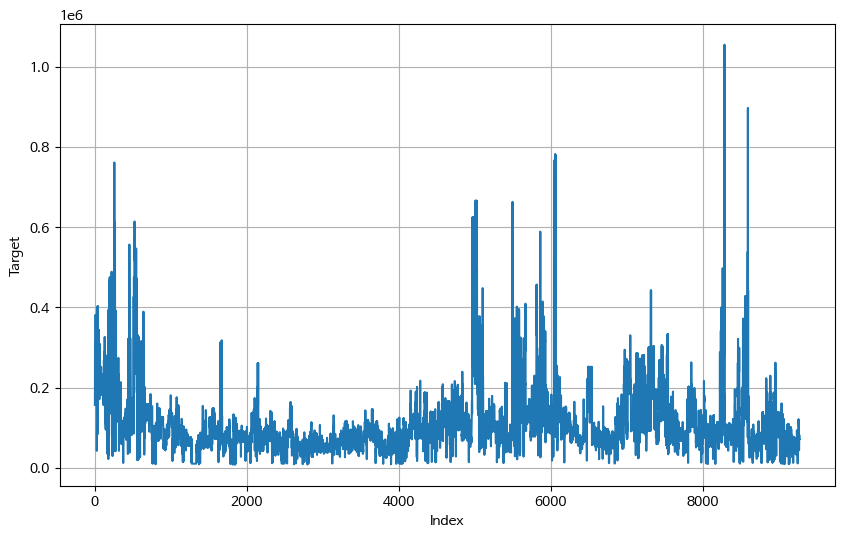

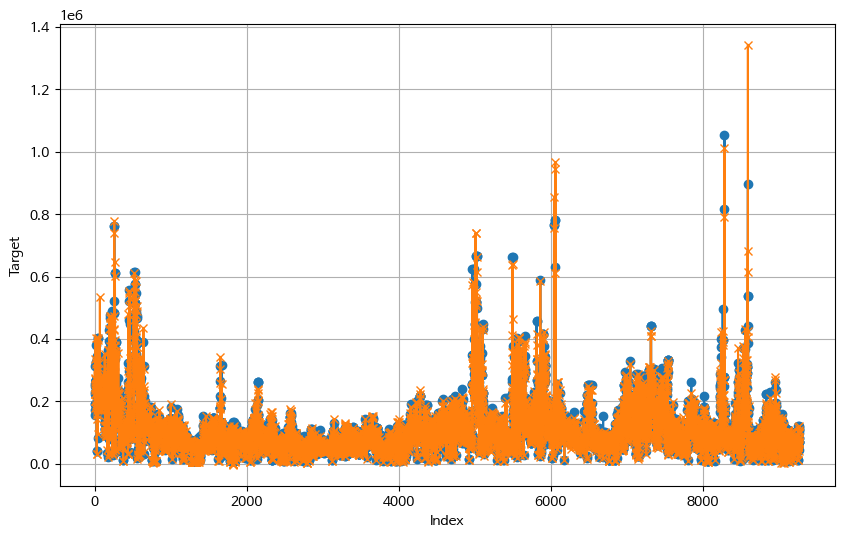

In [59]:
# 1개
plt.figure(figsize=(10, 6))
plt.plot(preds_df['target'])
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()


# 2개
plt.figure(figsize=(10, 6))
plt.plot(preds_df['target'], label='fs', marker='o')
plt.plot(output['target'], label='xgb', marker='x')
plt.xlabel('Index')
plt.ylabel('Target')
plt.grid(True)
plt.show()